# bank-sentinel

# section 1

A machine learning project by Joey Shiu and Noelle Koliadko in partial fulfillment of the requirements for CPTR 435: Machine Learning. 

This project is a binary classification problem designed to predict bank failure based on its financials as reported to the FDIC. The input consists of 26 numerical ratios derived from bank financial data. Insofar as possible, we have used the features outlined by Le, H.H., & Viviani, J.-L. (2018). These features will be further explained in a later section. The output is a binary class, where 1 represents survival and 0 represents failure. 

We have created a vanilla Artificial Neural Network architecture using the Keras/TensorFlow framework. We are evaluating the model on accuracy, precision, recall, and the F1 score. 

Data is extracted from a public API from the FDIC which can be found here: https://banks.data.fdic.gov/docs/

Bibliography:

>Le, H. H., & Viviani, J.-L. (2018). Predicting bank failure: An improvement by implementing a machine-learning approach to classical financial ratios. *Research in International Business and Finance, 44*, 16–25. https://doi.org/10.1016/j.ribaf.2017.07.104 

>Serrano-Cinca, C. & Gutiérrez-Nieto, B. (2013). Partial Least Square Discriminant Analysis for bankruptcy prediction. *Decision Support Systems, 54*(3), 1245-1255. https://doi.org/10.1016/j.dss.2012.11.015 

> Zhao, H., Sinha, A.P., & Ge, W. (2009). Effects of feature construction on classification performance: An empirical study in bank failure prediction. *Expert Systems with Applications, 36*(2), 2633-2644. https://doi.org/10.1016/j.eswa.2008.01.053 


## section 2

This section extracts data from year-end financials in 2021 for active banks for and from year-end financials in the year prior to failure for failed banks. We begin by defining functions that allow us to make API calls using the Elastic Search query syntax.

In [19]:
import requests
import pandas as pd
import math
from io import StringIO
from urllib.parse import quote_plus

### Construct API call

In [2]:
# function to get data from BankFind API
def getData(url: str, filter: str, fields: str, sortby: str = 'CERT', order: str = 'ASC', n: int = 10000, k: int = 0, suffix: str = '&format=csv&download=false&filename=data_file') -> pd.DataFrame:
    request = requests.get(url + 'filters=' + quote_plus(filter) + '&fields=' + quote_plus(fields) + '&sort_by=' + sortby + '&sort_order=' + order + '&limit=' + str(n) + '&offset=' + str(k) + suffix).text
    return pd.read_csv(StringIO(request))

In [3]:
# reset index and drop redundant columns for bank dataframe
def cleanbankdata(df: pd.DataFrame) -> None:
    df.set_index('CERT', inplace=True)
    df.drop('ID', axis = 1, inplace = True)

### Get lists of all banks 2006-present

In [4]:
# number of banks to get 
# note: in the selected time frame there are less than 5000 in each group, so the value of n is only for constraining test cases
n = 5000

In [6]:
# strings for getting lists of active and failed banks
institutionurl = 'https://banks.data.fdic.gov/api/institutions?'
filtersfailed = 'ACTIVE:0 AND DATEUPDT:[\"2006-01-01\" TO \"2023-12-31\"]'
filtersactive = 'ACTIVE:1 AND DATEUPDT:[\"2006-01-01\" TO \"2023-12-31\"]'
bankfields = 'STALP,NAME,ACTIVE,CERT,DATEUPDT'


# get failed banks
failedbanks = getData(institutionurl, filtersfailed, bankfields, n = n)
cleanbankdata(failedbanks)

# get active banks
activebanks = getData(institutionurl, filtersactive, bankfields, n = n)
cleanbankdata(activebanks)

In [7]:
failedbanks.head()

,ACTIVE,DATEUPDT,NAME,STALP
CERT,,,,
9,0,02/27/2008,Union Trust Company,ME
46,0,01/07/2022,Merchants Bank of Alabama,AL
47,0,07/10/2020,Traders & Farmers Bank,AL
57,0,11/21/2006,Community Bank,AL
59,0,01/09/2013,The Citizens Bank,AL


In [8]:
activebanks.head()

,ACTIVE,DATEUPDT,NAME,STALP
CERT,,,,
14,1,06/05/2023,State Street Bank and Trust Company,MA
35,1,09/02/2022,AuburnBank,AL
39,1,03/28/2023,Robertson Banking Company,AL
41,1,08/31/2022,Phenix-Girard Bank,AL
49,1,08/31/2022,Bank of Evergreen,AL


In [9]:
print(f'number of failed banks: {len(failedbanks)}')
print(f'number of active banks: {len(activebanks)}')

number of failed banks: 4948
number of active banks: 4611


### Get financials of banks

In [10]:
# global information
# financials

# gets financial data for all banks currently active from their year-end report in 2021
financialsurl = 'https://banks.data.fdic.gov/api/financials?'

featureslist =  ['NAME,RISDATE,CERT,REPYEAR,',
                'LNATRESR,ELNLOS,NIM,EAMINTAN,LNLSGRS,NTLNLS,EQ,ASSET5,' ,
                'RBCT1,IDT1RWAJR,EQTOTR,EQV,LNLSNET,LIAB,LIABEQR,LIABEQ,DEP,',
                'NIMY,NIMR,NONIXR,PTAXNETINCR,ITAX,',
                'ROA,ROE,NETINC,EEFFR,CHBAL,ASSET,BKPREM']
features = ''.join(featureslist)

featurenames = {'LNATRESR': 'LOAN LOSS RESERVE/GROSS LN&LS',
                'ELNLOS' : 'PROVISIONS FOR LN & LEASE LOSSES',
                'NIM' : 'NET INTEREST INCOME',
                'EAMINTAN' : 'AMORT & IMPAIR LOSS AST',
                'LNLSGRS' : 'LOANS AND LEASES, GROSS',
                'NTLNLS' : 'TOTAL LN&LS NET CHARGE-OFFS',
                'EQ' : 'Equity Capital',
                'ASSET5' : 'TOTAL ASSETS-CAVG5',
                'RBCT1' : 'TIER 1 RBC-PCA',
                'IDT1RWAJR' : 'TIER 1 RISK-BASED CAPITAL RATIO',
                'EQTOTR' : 'TOTAL EQUITY CAPITAL RATIO',
                'EQV' : 'BANK EQUITY CAPITAL/ASSETS',
                'LNLSNET' : 'LOANS AND LEASES-NET',
                'CUSLI' : 'CUSTOMERS ACCEPTANCES',
                'LIAB' : 'TOTAL LIABILITIES',
                'LIABEQR' : 'TOTAL LIABILITIES & CAPITAL RATIO',
                'LIABEQ' : 'TOTAL LIABILITIES & CAPITAL',
                'DEP' : 'Total deposits',
                'NIMY' : 'NET INTEREST MARGIN',
                'NIMR' : 'NET INTEREST INCOME RATIO',
                'IOTHFEE' : 'OTHER FEE INCOME',
                'NONIXR' : 'TOTAL NONINTEREST EXPENSE RATIO',
                'PTAXNETINCR' : 'PRE-TAX NET INCOME OPERATING INCOME RATIO',
                'ITAX' : 'APPLICABLE INCOME TAXES',
                'ROA' : 'Return on assets (ROA)',
                'ROE' : 'Return on equity (ROE)',
                'NETINC' : 'Net income',
                'EEFFR' : 'EFFICIENCY RATIO',
                'CHBAL' : 'CASH & DUE FROM DEPOSITORY INST',
                'ASSET' : 'Total assets',
                'BKPREM' : 'PREMISES AND FIXED ASSETS'
                }

#### Active Banks

In [11]:
activefilters = 'RISDATE:20211231'
activefinancials = getData(financialsurl, activefilters, features)

In [12]:
activefinancials.isna().sum()

ASSET           0
ASSET5          0
BKPREM         17
CERT            0
CHBAL           0
DEP             0
EAMINTAN       17
EEFFR           0
ELNLOS         17
EQ             17
EQTOTR          0
EQV             0
ID              0
IDT1RWAJR       0
ITAX           17
LIAB            0
LIABEQ          0
LIABEQR         0
LNATRESR        0
LNLSGRS         0
LNLSNET         0
NAME            0
NETINC         17
NIM            17
NIMR            0
NIMY            0
NONIXR          0
NTLNLS         17
PTAXNETINCR     0
RBCT1          17
REPYEAR         0
RISDATE         0
ROA             0
ROE            17
dtype: int64

In [13]:
print(f'number of financial reports (banks): {len(activefinancials)}')

number of financial reports (banks): 4904


In [14]:
# join bank data with financials
activedata = activebanks.merge(activefinancials, on = 'CERT', how = 'left', suffixes=['_b', '_f'])
# drop NAs
activedata.dropna(inplace= True)

In [16]:
activedata.head()

,CERT,ACTIVE,DATEUPDT,NAME_b,STALP,ASSET,ASSET5,BKPREM,CHBAL,DEP,...,NIMR,NIMY,NONIXR,NTLNLS,PTAXNETINCR,RBCT1,REPYEAR,RISDATE,ROA,ROE
0,14,1,06/05/2023,State Street Bank and Trust Company,MA,311063000.0,315584400.0,2250000.0,109322000.0,260805000.0,...,0.632477,0.776841,2.573955,2000.0,1.007971,18845000.0,2021.0,20211231.0,0.841930,9.88
1,35,1,09/02/2022,AuburnBank,AL,1104523.0,1030987.0,41786.0,78839.0,996948.0,...,2.331261,2.514126,1.911178,79.0,0.868488,100059.0,2021.0,20211231.0,0.741522,7.52
2,39,1,03/28/2023,Robertson Banking Company,AL,412189.0,392534.0,3964.0,54893.0,374169.0,...,3.080243,3.411668,2.381705,-8.0,1.680874,36507.0,2021.0,20211231.0,1.570055,16.73
3,41,1,08/31/2022,Phenix-Girard Bank,AL,285239.0,261810.0,1689.0,49033.0,242418.0,...,2.627860,2.780162,2.351705,41.0,1.134792,36019.0,2021.0,20211231.0,1.678698,12.24
4,49,1,08/31/2022,Bank of Evergreen,AL,75734.0,71653.2,897.0,5253.0,66576.0,...,3.077322,3.282217,2.641892,13.0,0.880631,8959.0,2021.0,20211231.0,0.736883,5.88


#### Failed banks

In [17]:
# create a new column containing one year prior to the year of failure

failedbanks['prevYr'] = failedbanks.DATEUPDT.str.rsplit('/', expand = True, n = 1)[1].astype(int) - 1
failedbanks['targetdate'] = failedbanks.prevYr * 10000 + 1231


In [18]:
## this cell takes > 1 minute to execute

# get all financial data in the selected date range for the banks in the list of failed banks
# BankFind does not like this query! It balks when you ask for too much data.
# We will make multiple queries, store them in a list, then pd.concat them at the end
failedfinancialslist = []

# This query is split into two nested loops:
# first we divide the divide the number of banks into groups of 1000
n_failed = len(failedbanks)
n_bins = math.ceil(n_failed / 1000)
cert = failedbanks.index.to_series().reset_index(drop = True).astype(str)


for i in range(n_bins):
    # develop the query for each set of 1000 banks
    bankIDstring = ' OR '.join(cert.loc[i*1000 : min(i*1000 + 999, n_failed - 1)])
    failedfilter = f'CERT:({bankIDstring}) AND REPYEAR:[2005 TO 2023]'

    # second (nested) loop to ensure all the data is collected
    # BankFind cuts off at 10k rows, but since there are 72 quarters in the date range, there will be many more entries. 
    # The following loop pulls data in chunks of 10k until all data is collected. 
    j = 0
    while True:
        try:
            # for optimal performance, append to python list and perform pd.concat at the end
            failedfinancialslist.append(getData(financialsurl, failedfilter, features, k = j))
            j += 10000
        except:
            break

# concatenate all into one dataframe
failedfinancials = pd.concat(failedfinancialslist)

In [19]:
failedfinancials.head()

,ASSET,ASSET5,BKPREM,CERT,CHBAL,DEP,EAMINTAN,EEFFR,ELNLOS,EQ,...,NIMR,NIMY,NONIXR,NTLNLS,PTAXNETINCR,RBCT1,REPYEAR,RISDATE,ROA,ROE
0,509057,495183.50,5454.0,9,7217,290464,0.0,70.380792,-215.0,33724.0,...,3.271514,3.541336,3.030796,21.0,1.449160,34379.0,2005,20050331,1.011342,14.71
1,518990,503119.00,5865.0,9,9381,306989,0.0,68.484681,-215.0,34610.0,...,3.299816,3.575826,2.949998,42.0,1.442999,34978.0,2005,20050630,1.012882,14.89
2,530632,509997.25,5842.0,9,15625,335075,0.0,68.420729,-215.0,34179.0,...,3.247571,3.531030,2.909092,46.0,1.398873,34845.0,2005,20050930,0.982203,14.64
3,523535,512704.80,5994.0,9,9724,335239,0.0,69.585168,-215.0,34053.0,...,3.187019,3.460747,2.928196,41.0,1.321813,35439.0,2005,20051231,0.953570,14.30
4,536475,530005.00,6212.0,9,11061,317671,0.0,77.258687,0.0,36862.0,...,2.946387,3.189305,3.020349,-34.0,0.889048,38325.0,2006,20060331,0.664145,9.93


In [20]:
# join bank data with financials
faileddata = failedbanks.merge(failedfinancials, left_on = ['CERT', 'targetdate'], right_on = ['CERT', 'RISDATE'], how = 'left', suffixes=['_b', '_f'])
# drop NA values
faileddata.dropna(inplace = True)
# drop unneeded columns
faileddata.drop(['prevYr', 'targetdate'], axis = 1, inplace = True)

In [21]:
faileddata.head()

,CERT,ACTIVE,DATEUPDT,NAME_b,STALP,ASSET,ASSET5,BKPREM,CHBAL,DEP,...,NIMR,NIMY,NONIXR,NTLNLS,PTAXNETINCR,RBCT1,REPYEAR,RISDATE,ROA,ROE
0,9,0,02/27/2008,Union Trust Company,ME,539169.0,542956.8,8232.0,15627.0,342440.0,...,2.866158,3.121476,3.365829,402.0,0.465783,31137.0,2007.0,20071231.0,0.395796,5.72
1,46,0,01/07/2022,Merchants Bank of Alabama,AL,382952.0,384777.4,3344.0,28545.0,345793.0,...,2.898039,3.075171,2.778490,45.0,0.879210,35597.0,2021.0,20211231.0,0.692868,7.46
2,47,0,07/10/2020,Traders & Farmers Bank,AL,366379.0,366703.4,8819.0,7459.0,288635.0,...,3.368117,3.649053,2.641644,193.0,0.934270,59738.0,2019.0,20191231.0,0.773104,4.97
3,57,0,11/21/2006,Community Bank,AL,564639.0,548678.0,22558.0,18650.0,443226.0,...,3.769971,4.374382,4.175309,685.0,0.695854,39579.0,2005.0,20051231.0,0.423564,5.18
4,59,0,01/09/2013,The Citizens Bank,AL,172397.0,169502.0,426.0,41938.0,143109.0,...,2.962207,3.320306,1.479039,366.0,1.674317,28606.0,2012.0,20121231.0,1.136860,6.84


### Recombine the data

In [22]:
# combine active bank data and failed data into one df
alldata = pd.concat([activedata, faileddata])
# drop columns that will not be part of the ML model
alldata.drop(['CERT', 'DATEUPDT', 'NAME_b', 'STALP', 'ID', 'NAME_f', 'REPYEAR', 'RISDATE'], axis = 1, inplace = True)

In [23]:
alldata

,ACTIVE,ASSET,ASSET5,BKPREM,CHBAL,DEP,EAMINTAN,EEFFR,ELNLOS,EQ,...,NETINC,NIM,NIMR,NIMY,NONIXR,NTLNLS,PTAXNETINCR,RBCT1,ROA,ROE
0,1,311063000.0,315584400.0,2250000.0,109322000.0,260805000.0,243000.0,69.913938,-29000.0,27821000.0,...,2657000.0,1996000.0,0.632477,0.776841,2.573955,2000.0,1.007971,18845000.0,0.841930,9.88
1,1,1104523.0,1030987.0,41786.0,78839.0,996948.0,0.0,70.225961,-600.0,100951.0,...,7645.0,24035.0,2.331261,2.514126,1.911178,79.0,0.868488,100059.0,0.741522,7.52
2,1,412189.0,392534.0,3964.0,54893.0,374169.0,0.0,57.542931,300.0,36189.0,...,6163.0,12091.0,3.080243,3.411668,2.381705,-8.0,1.680874,36507.0,1.570055,16.73
3,1,285239.0,261810.0,1689.0,49033.0,242418.0,0.0,66.720850,100.0,36064.0,...,4395.0,6880.0,2.627860,2.780162,2.351705,41.0,1.134792,36019.0,1.678698,12.24
4,1,75734.0,71653.2,897.0,5253.0,66576.0,0.0,73.829953,40.0,8994.0,...,528.0,2205.0,3.077322,3.282217,2.641892,13.0,0.880631,8959.0,0.736883,5.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,0,238443.0,233908.8,4206.0,17551.0,213291.0,0.0,63.086740,0.0,25002.0,...,3463.0,7839.0,3.351306,3.537314,2.493707,281.0,1.459116,22961.0,1.480492,14.21
4943,0,435050.0,448144.2,11383.0,15911.0,370924.0,0.0,93.608679,2457.0,34331.0,...,-304.0,17805.0,3.973052,4.523389,3.889150,1459.0,-0.282721,35096.0,-0.067835,-0.88
4944,0,145799.0,142465.8,4655.0,23540.0,130522.0,0.0,60.822862,-300.0,14148.0,...,2233.0,4375.0,3.070912,3.333547,2.106470,-115.0,1.567394,14696.0,1.567394,15.02
4946,0,2064652.0,2120586.0,2631.0,425.0,1875835.0,0.0,82.751328,0.0,155471.0,...,14095.0,80390.0,3.790933,3.893613,5.185123,0.0,1.080786,143700.0,0.664675,9.44


In [24]:
# store cached data for use in another notebook
alldata.to_csv('alldata2.csv')

In [2]:
# only run this cell to bypass the data loading stage
alldata = pd.read_csv('alldata2.csv')
alldata.drop(columns = ['Unnamed: 0'], inplace = True)

The features that we are using are not all immediately available from the FDIC database. We need to perform feature engineering to create the desired features. Le, H.H., & Viviani, J.-L. divided their features into 5 categories to represent bank health in the areas of Loan Quality, Capital Quality, Operations, Profitability, and Liquidity. 

##### Loan Quality
+ LNATRESR is Loan Loss reserve / Gross Loans and leases
+ LLPNIR is Loan loss provision / net interest revenue
+ ILGL is Impaired losses (loans) / gross loans
+ NCOGL is Net charge off / Gross loans
+ ILEQ is Impaired loans / equity

##### Capital Quality
+ IDT1RWAJR is the Tier 1 capital ratio
+ EQTOTR is the Total equity capital ratio
+ EQV is Equity / Assets
+ EQNL is Equity / Net Loans
+ EQLIAB is Equity / Liabilities
+ LIABEQR is Total Capital / Assets
+ TCNL is Total capital / Net Loans
+ TCDEP is Total capital / deposits
+ TCLIAB is Total capital / Liabilities

##### Operations
+ NIMY is the Net Interest Margin
+ NIMR is the Net Interest Income ratio
+ NONIXR is the Non-Interest expense ratio
+ PTAXNETINCR is the Pre-tax Operating Income ratio
+ TAVAST is Income taxes / avg assets

##### Profitability 
+ ROA is Return on Assets
+ ROE is Return on Equity
+ NIEQ is net income / equity
+ EEFFR is the Efficiency Ratio

##### Liquidity
+ NLTA is net loans / total assets
+ NLTD is net loans / total deposits
+ LATD is (assets - fixed assets) / total deposits


In [21]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [4]:
class CustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # nothing to fit
    
    def transform(self, X, y=None):
        # Z2, Loan loss provision / net interest revenue
        LLPNIR = X.ELNLOS / X.NIM

        # Z3, Impaired loans / gross loans
        ILGL = X.EAMINTAN / X.LNLSGRS

        # Z4, Net charge off / Gross loans
        NCOGL = X.NTLNLS / X.LNLSGRS

        # Z5, Impaired loans / equity
        ILEQ = X.EAMINTAN / X.EQ

        # Z9, Equity / Net Loans
        EQNL = X.EQ / X.LNLSNET
        
        # no data for Z10

        # Z11, Equity / Liabilities
        EQLIAB = X.EQ / X.LIAB

        # Z13, Total capital / Net Loans
        TCNL = X.LIABEQ / X.LNLSNET

        # Z14, Total capital / deposits
        TCDEP = X.LIABEQ / X.DEP

        # Z15, Total capital / Liabilities
        TCLIAB = X.LIABEQ / X.LIAB

        # no data for Z18

        # Z21, taxes / avg assets
        TAVAST = X.ITAX / X.ASSET5

        # Z24, net income / equity
        NIEQ = X.NETINC / X.EQ

        # no data for Z25 and Z26, use Efficiency ratio instead

        # Z27 , net loans / total assets
        NLTA = X.LNLSNET / X.ASSET

        # not sure how Z28 and Z29 are different, use net loans / total deposits
        NLTD = X.LNLSNET / X.DEP

        # not sure how Z30 and 31 are different, use liquid assets / total deposits = (assets - fixed assets) / total deposits
        LATD = (X.ASSET - X.BKPREM) / X.DEP

        # construct final table
        finalTable = pd.concat([X.LNATRESR, LLPNIR, ILGL, NCOGL, ILEQ, X.IDT1RWAJR, X.EQTOTR, X.EQV, EQNL, EQLIAB, X.LIABEQR, TCNL, TCDEP, TCLIAB, X.NIMY, X.NIMR, X.NONIXR, X.PTAXNETINCR, TAVAST, X.ROA, X.ROE, NIEQ, X.EEFFR, NLTA, NLTD, LATD, X.ACTIVE], axis = 1)
        
        
        # drop rows that have resulted in division by zero
        finalTable.replace([np.inf, -np.inf], np.nan, inplace=True)
        finalTable.dropna(inplace = True)

        finalTable.columns = ['LNATRESR', 'LLPNIR', 'ILGL', 'NCOGL', 'ILEQ', 'IDT1RWAJR', 'EQTOTR', 'EQV', 'EQNL', 'EQLIAB', 'LIABEQR', 'TCNL', 'TCDEP', 'TCLIAB', 'NIMY', 'NIMR', 'NONIXR', 'PTAXNETINCR', 'TAVAST', 'ROA', 'ROE', 'NIEQ', 'EEFFR', 'NLTA', 'NLTD', 'LATD', 'ACTIVE']
        return finalTable

In [5]:
# this pipeline should be run before the data is split into features and targets or into training/test sets. 
# there is no fitting involved, only feature engineering in deriving features from other features.
# some of these ratios lead to division by zero, so these rows AND THEIR CORRESPONDING TARGETS must be dropped from the dataset before any splitting is done

pre_split_pipeline = Pipeline([
                    ('feature transformer', CustomFeatures())
                    ])

transformed_data = pre_split_pipeline.fit_transform(alldata)

## section 3

At this stage, the data has been transformed into all the features we need for our model. Each observation (row) has 26 numerical features and one binary target class. All other information, such as bank names, locations, and report dates, have been removed. For all the active banks (ACTIVE == 1), the financials are extracted from the year-end report in 2021. For all failed banks (ACTIVE == 0), the financials are extracted from the year-end report in the year prior to its failure.  In the cells below are summaries and visualizations of the features.

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
print(f'number of total entries: {len(transformed_data)}')
print(f'number of failed banks: {len(transformed_data[transformed_data.ACTIVE == 0])}')
print(f'number of active banks: {len(transformed_data[transformed_data.ACTIVE == 1])}')


number of total entries: 8999
number of failed banks: 4455
number of active banks: 4544


In [13]:
# summary stats part 1
transformed_data.iloc[:,:13].describe()

,LNATRESR,LLPNIR,ILGL,NCOGL,ILEQ,IDT1RWAJR,EQTOTR,EQV,EQNL,EQLIAB,LIABEQR,TCNL,TCDEP
count,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,1.660919,0.149072,0.000753,0.005226,0.004805,13.515533,10.846729,10.844141,2.324809,0.140436,99.999987,19.615244,2.532687
std,1.471546,0.995114,0.012312,0.025492,0.131817,29.199185,5.283796,5.283723,163.929937,0.583395,0.000586,1603.955353,77.191838
min,0.000000,-30.572115,-0.006898,-0.111111,-9.338369,-16.532734,-9.064625,-9.064625,-0.139313,-0.083112,99.951705,1.010783,0.957469
25%,1.039190,0.000000,0.000000,-0.000004,0.000000,6.937602,8.657770,8.657429,0.133052,0.094784,100.000000,1.381696,1.119396
50%,1.329683,0.018559,0.000000,0.000271,0.000000,12.716861,10.145518,10.144480,0.169274,0.112900,100.000000,1.613147,1.156866
75%,1.800926,0.058214,0.000016,0.002153,0.000098,16.397245,12.115134,12.112895,0.227484,0.137823,100.000000,2.019153,1.219370
max,52.786885,57.000000,0.838393,1.352185,5.240343,1898.930481,96.942795,96.942795,15432.500000,31.709619,100.009397,152124.500000,5605.000000


In [14]:
# summary stats part 2
transformed_data.iloc[:,14:26].describe()

,NIMY,NIMR,NONIXR,PTAXNETINCR,TAVAST,ROA,ROE,NIEQ,EEFFR,NLTA,NLTD,LATD
count,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000,8999.000000
mean,3.435910,3.170638,3.035396,0.724444,0.001767,0.556133,1.983589,-0.088186,82.350812,0.599565,1.586669,2.503288
std,1.143492,1.039288,3.386599,6.899357,0.014628,5.575222,34.130906,12.204134,174.401213,0.165627,52.185687,76.447845
min,-0.790665,-0.493900,0.006087,-52.101950,-0.135066,-52.107642,-754.830000,-887.458333,0.000000,0.000007,0.000007,0.875144
25%,2.911934,2.697884,2.149825,0.439872,0.000000,0.378957,3.335000,0.033825,58.649462,0.495257,0.572114,1.101723
50%,3.411487,3.156106,2.640676,1.057623,0.001144,0.886578,8.070000,0.079723,68.711505,0.619906,0.720184,1.140333
75%,3.908228,3.598878,3.242771,1.537861,0.003227,1.294408,12.480000,0.121538,82.145011,0.723748,0.862097,1.201284
max,24.048977,21.646414,170.398310,615.683193,1.292932,486.389989,1273.250000,464.450000,7780.769231,0.989332,4244.168639,5513.000000


<Axes: >

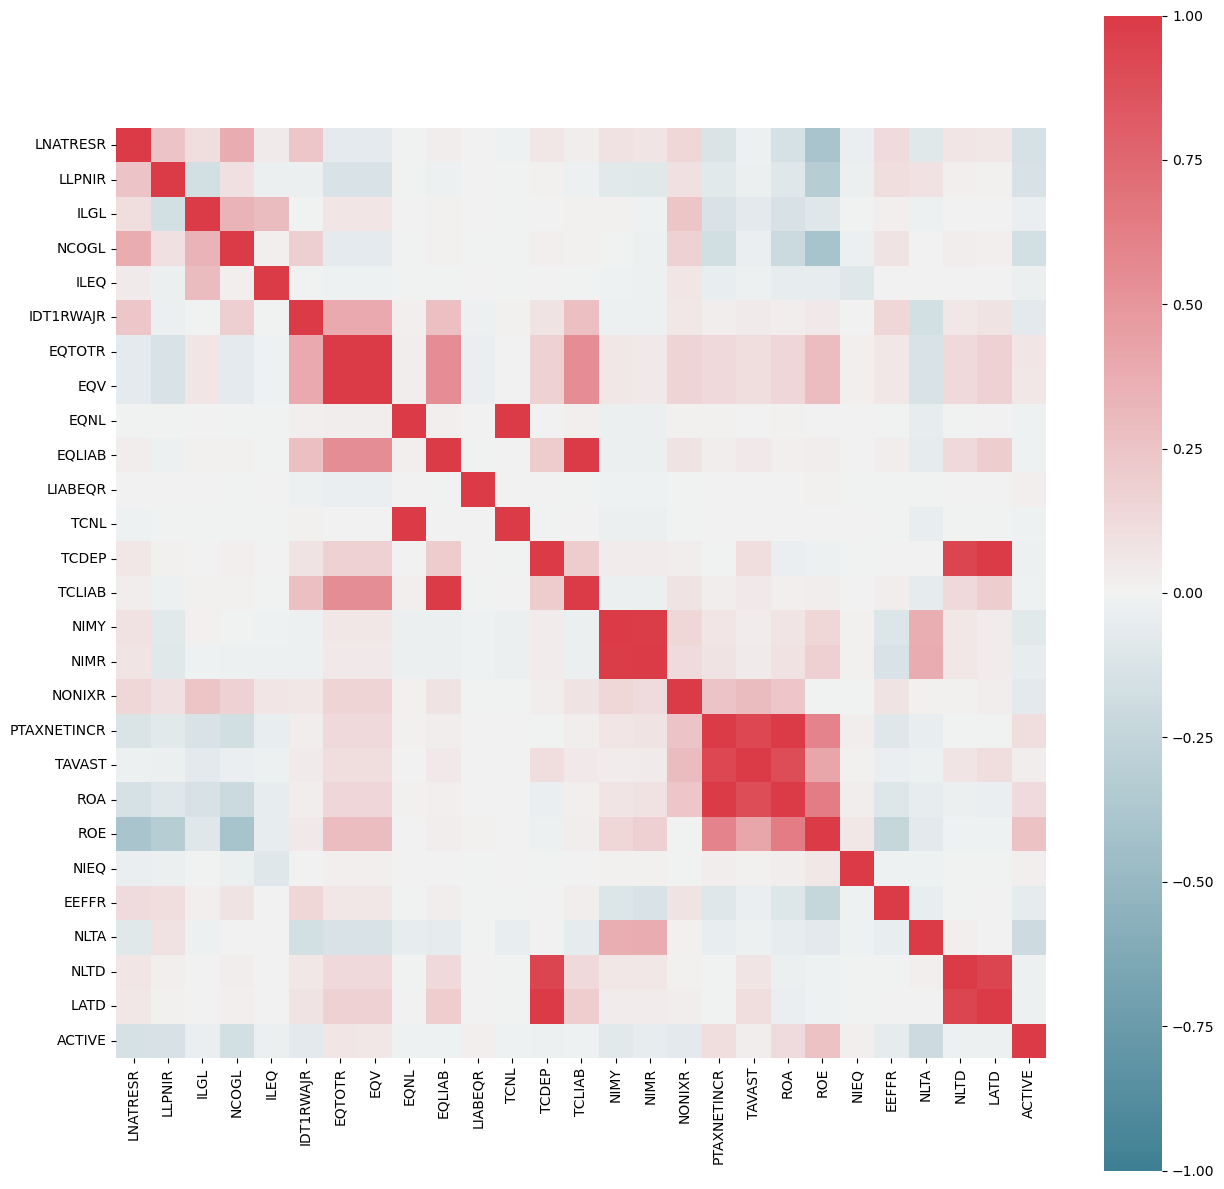

In [18]:
# correlation matrix visualization

plt.figure(figsize=(15, 15))
corr = transformed_data.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square = True)

array([[<Axes: title={'center': 'LNATRESR'}>,
        <Axes: title={'center': 'LLPNIR'}>,
        <Axes: title={'center': 'ILGL'}>,
        <Axes: title={'center': 'NCOGL'}>,
        <Axes: title={'center': 'ILEQ'}>],
       [<Axes: title={'center': 'IDT1RWAJR'}>,
        <Axes: title={'center': 'EQTOTR'}>,
        <Axes: title={'center': 'EQV'}>,
        <Axes: title={'center': 'EQNL'}>,
        <Axes: title={'center': 'EQLIAB'}>],
       [<Axes: title={'center': 'LIABEQR'}>,
        <Axes: title={'center': 'TCNL'}>,
        <Axes: title={'center': 'TCDEP'}>,
        <Axes: title={'center': 'TCLIAB'}>,
        <Axes: title={'center': 'NIMY'}>],
       [<Axes: title={'center': 'NIMR'}>,
        <Axes: title={'center': 'NONIXR'}>,
        <Axes: title={'center': 'PTAXNETINCR'}>,
        <Axes: title={'center': 'TAVAST'}>,
        <Axes: title={'center': 'ROA'}>],
       [<Axes: title={'center': 'ROE'}>,
        <Axes: title={'center': 'NIEQ'}>,
        <Axes: title={'center': 'EEFFR'}>,

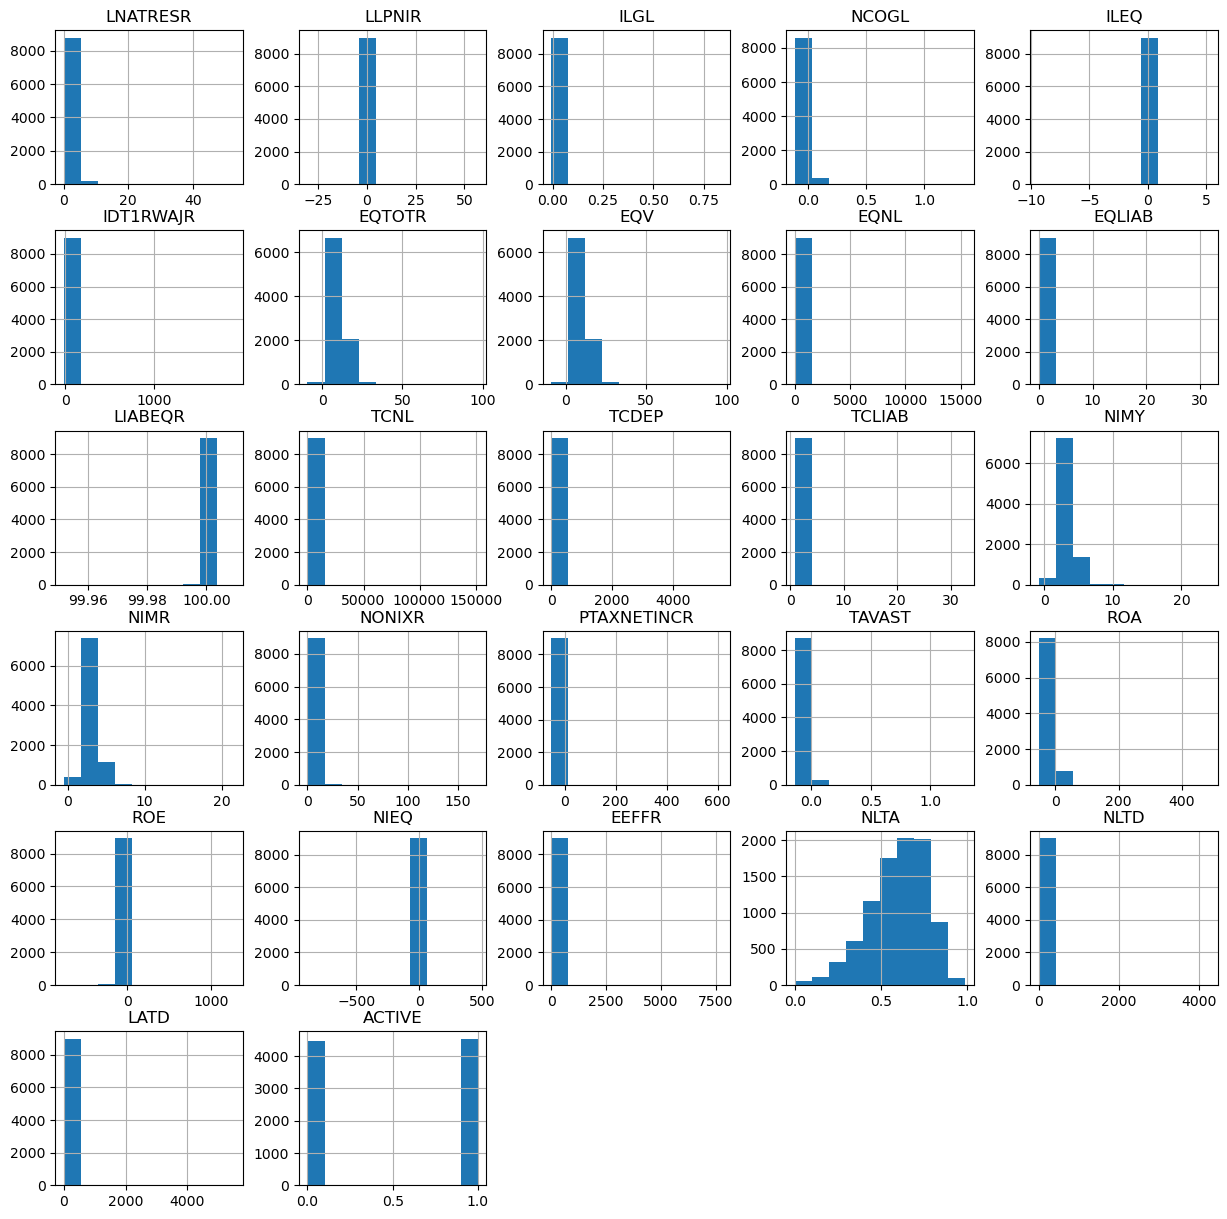

In [14]:
# generate histograms 

transformed_data.hist(figsize=(15,15))

We note that some of the features are correlated. We may consider omitting features to simplify the model, but because we are attempting to replicate the features previously described, we will keep all features as-is. We also observe from the histograms that most of the features are clustered at one mode, while there are outliers too small to appear in the histogram (but we can observe from the min/max values in the summary). Feature scaling should help somewhat with this problem. 

## section 4

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
# split data
X = transformed_data.drop(columns = 'ACTIVE')
y = transformed_data.ACTIVE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)

In [23]:
# post split pipeline

post_split_pipeline = Pipeline([
                                ('scaler', StandardScaler())
                                ])

# assign scaled pipeline values back to dataframes
X_train.values[:] = post_split_pipeline.fit_transform(X_train)
X_test.values[:] = post_split_pipeline.transform(X_test)

Note that the pipeline does not handle missing values as they were already excluded in a previous step in the data extraction. We chose the drop approach for two reasons. First, the dataset was sufficiently large that losing a few observations would have minimal impact on the model training. Second, many of the NA values came from a set of observations that had many NA values (i.e. several rows with many NA columns), which suggests that those observation are poor quality datapoints. In such cases, their utility to the training process would be low and imputation would be a stretch.

## section 5

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### KNN baseline

In [33]:
knnmodel = KNeighborsClassifier(n_neighbors = 9)
knnmodel.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=9)

In [34]:
knnpred = knnmodel.predict(X_test)

### Neural net

In [24]:
# Create model
model6 = Sequential([
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

# Compile the model
model6.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.legacy.Adam(0.01),
    metrics = ['accuracy']
)

# Train the model
history6 = model6.fit(X_train,
                    y_train,
                    epochs=150,
                    validation_data=(X_test, y_test),
                    verbose=1)

2023-12-08 12:37:50.955569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:37:51.075562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:37:51.075619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:37:51.089063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

Epoch 1/150
  5/225 [..............................] - ETA: 2s - loss: 0.6722 - accuracy: 0.6313   

2023-12-08 12:37:56.289370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


225/225 [==============================] - 5s 12ms/step - loss: 0.5381 - accuracy: 0.7495 - val_loss: 0.4470 - val_accuracy: 0.7911
Epoch 2/150
225/225 [==============================] - 2s 10ms/step - loss: 0.4674 - accuracy: 0.7812 - val_loss: 0.4146 - val_accuracy: 0.8044
Epoch 3/150
225/225 [==============================] - 5s 23ms/step - loss: 0.4388 - accuracy: 0.7983 - val_loss: 0.4213 - val_accuracy: 0.8128
Epoch 4/150
225/225 [==============================] - 6s 27ms/step - loss: 0.4218 - accuracy: 0.8059 - val_loss: 0.3896 - val_accuracy: 0.8289
Epoch 5/150
225/225 [==============================] - 2s 11ms/step - loss: 0.4197 - accuracy: 0.8139 - val_loss: 0.3929 - val_accuracy: 0.8211
Epoch 6/150
225/225 [==============================] - 5s 23ms/step - loss: 0.4015 - accuracy: 0.8223 - val_loss: 0.3907 - val_accuracy: 0.8206
Epoch 7/150
225/225 [==============================] - 4s 19ms/step - loss: 0.4032 - accuracy: 0.8148 - val_loss: 0.3853 - val_accuracy: 0.8328
Epoc

In [36]:
model6.save('transformed_model.keras')

In [ ]:
# run this cell to bypass training step
# from keras.models import load_model
# model6 = load_model('transformed_model.keras')

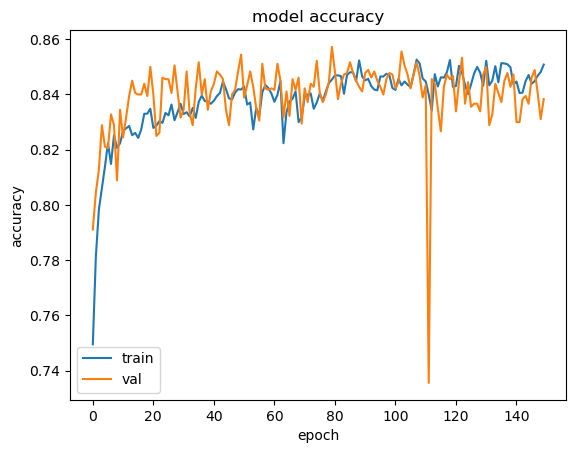

In [28]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

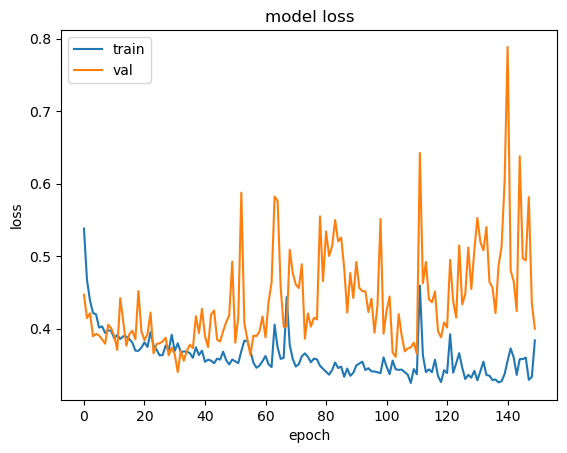

In [29]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We observe some erratic movements in the graphs of loss and accuracy, but in general we found that additional epochs did little to improve the model.  

In [35]:
annpred = model6.predict(X_test)

57/57 [==============================] - 1s 9ms/step


### Result comparison

In [37]:
def metrics(y_true, y_pred):
    print(f'accuracy: {accuracy_score(y_true, y_pred >= 0.5) * 100 : .2f}%')
    print(f'recall: {recall_score(y_true, y_pred >= 0.5) * 100 : .2f}%')
    print(f'precision: {precision_score(y_true, y_pred >= 0.5) * 100 : .2f}%')
    print(f'f1: {f1_score(y_true, y_pred >= 0.5) * 100 : .2f}%')

In [39]:
print('neural network')
metrics(y_test, annpred)

print('\nknn')
metrics(y_test, knnpred)

neural network
accuracy:  83.83%
recall:  92.42%
precision:  78.80%
f1:  85.07%

knn
accuracy:  78.00%
recall:  83.39%
precision:  75.18%
f1:  79.07%


We tried several values of k for the knn approach, as well as different architectures for the neural network, but there was little effect. Overall, we conclude that the neural network outperformed the knn model in every metric. However, given an accuracy of around 84%, the neural network still has room for improvement. 

We also note that our model outperformed that of Le, H.H., & Viviani, J.-L. Of the architectures they tried, their highest precision score was 75.8%, their highest recall 75.3%, and their highest F-score was 75%. They did not report model accuracy. Thus, of all the metrics reported, our model performed better.

## section 6

While 84% is an impressive accuracy score for this type of model, it is still not high enough to be useful in practice. One possible idea is to increase the number of features. The FDIC database provides an incomprehensible number of features, many of which we had to ignore. While the features we chose were based on some economic theory and previous empirical work, machine learning allows us to easily analyze large datasets with many more features. We also note that models that were trained prior to feature engineering performed similarly to those after, which suggests that the work of feature transformation was probably unnecessary and can be skipped in the future in the interest of time. 

We would also like to convert this model into a time-series classification model, as was the work done by the original researchers. They used 5 year lookback windows for each observation, which provides a more robust and complete picture of what is happening to a bank's financials in the years leading to a collapse. However, this dramatically expands the complexity of the data extraction, model designing, and model training processes. For simplicity in this project, we chose to use a single time step, but using a time series may further improve the model. 